### Master of Applied Artificial Intelligence

**Course: TC4033 - Computational Vision for Images and Video**

<img src="./../assets/logo.png" alt="Image Alt Text" width="500"/>

**Region growing**

Tutor: Dr. Gilberto Ochoa


Team members:
* Alfonso de Lucas Espinosa - A01795118
* Ignacio Jose Aguilar Garcia - A00819762
* Alejandro Calderon Aguilar - A01795353
* Ricardo Mar Cupido - A01795394
* Mario Fonseca Martinez - A01795228

### Importing Libraries <a class="anchor" id="libraries" ></a>

In [28]:
import cv2
import matplotlib.pyplot as plt
from scipy import signal as sig
import numpy as np
from PIL import Image

### Region Growing Algorithm

In [29]:
class RegionGrowing():
    def __init__(self):
        pass
    
    def gaussian_noise(self, image, mu = 0, sigma=0.1):
        """
        Adds Gaussian noise to an image.

        Parameters:
        - image (numpy array): The input image to which noise will be added.
        - mu (float, optional): Mean of the Gaussian distribution (default is 0).
        - sigma (float, optional): Standard deviation of the Gaussian distribution (default is 0.1).

        Returns:
        - numpy array: The image with added Gaussian noise.
        """
        # Generate Gaussian noise with the same shape as the input image
        noise = np.random.normal(mu, sigma, image.shape)
        # Add the noise to the image and return the result
        return image + noise
    
    def __call__(self, seed, image, threshold, dist=4, max_it = 1e6):
        """
        Performs region growing segmentation on an image.

        Parameters:
        - seed (tuple): Coordinates (x, y) of the starting pixel for region growing.
        - image (numpy array): The grayscale image on which segmentation is performed.
        - threshold (float): The maximum allowed intensity difference for region growth.
        - dist (int, optional): Defines the neighborhood type: 
            - 4 for 4-connectivity (default)
            - 8 for 8-connectivity
        - max_it (int, optional): Maximum number of iterations before stopping (default is 1e6).

        Returns:
        - numpy array: A binary mask of the segmented region.
        """
        # Initialize the seed point
        x0, y0 = seed
        # Create a mask to store the segmented region
        mask = np.zeros(image.shape)
        # Create an array to keep track of visited pixels
        visited_pixels = np.zeros(image.shape)
        
        # Get the dimensions of the image
        N, M = image.shape
        
        # Initialize stack with the seed point
        stack = [(x0, y0)]
        # Initialize iteration counter
        it = 0
        
        # Start region growing loop
        while len(stack) > 0:
            # Pop the last pixel from the stack
            x0, y0 = stack.pop()
            
            # Get neighboring pixels based on the chosen connectivity (4 or 8)
            neighbours = self._N4(x0, y0, M,N) if dist == 4  else self._N8(x0, y0, M, N)
            
            # Iterate through neighbors to decide whether to add them to the region
            for x1, y1 in neighbours:
                # 1. Check if intensity difference is within the threshold
                # 2. Ensure the pixel is not already in the mask
                # 3. Ensure the pixel hasn't been visited
                if self._distance(x0, y0, x1, y1, image) <= threshold and mask[y1,x1] == 0 and visited_pixels[y1, x1] == 0:
                    # Add the pixel to the stack for further processing
                    stack.append((x1, y1))
           
            # Mark the current pixel as part of the segmented region
            mask[y0, x0] = 1
            # Mark the current pixel as visited
            visited_pixels[y0, x0] = 1
            # Increment iteration count
            it = it + 1
            
            # Stop if the maximum number of iterations is exceeded
            if it > max_it:
                print("overgrowing")
                break
        
        # Return the final segmented mask
        return mask

    def _distance(self, x0, y0, x1, y1, image):
        """
        Computes the absolute intensity difference between two pixels in an image.

        Parameters:
        - x0, y0 (int): Coordinates of the first pixel.
        - x1, y1 (int): Coordinates of the second pixel.
        - image (numpy array): Grayscale image represented as a 2D array.

        Returns:
        - float: The absolute difference in intensity between the two pixels.
        """
        
        # Get the intensity value of the first pixel
        v0 = image[y0, x0]
        # Get the intensity value of the second pixel
        v1 = image[y1, x1]
        # Compute and return the absolute intensity difference
        return abs(v1 - v0)

    def _N4(self, x0, y0, M, N):
        """
        Computes the 4-connected neighbors of a given pixel (x0, y0).

        Parameters:
        - x0, y0 (int): Coordinates of the current pixel.
        - M (int): Width of the image (number of columns).
        - N (int): Height of the image (number of rows).

        Returns:
        - list of tuples: A list of neighboring pixel coordinates (x, y) in 4-connectivity.
        """
        # List to store neighbours
        neighbours = []

        # 4-connected neighbours (horizontal and vertical)
        if x0 + 1 < M:
            # Bottom
            neighbours.append((x0 + 1, y0))
        if 0 < x0 - 1:
            # Top
            neighbours.append((x0 - 1, y0))
        if y0 + 1 < N:
            # Right
            neighbours.append((x0, y0 + 1))
        if 0 < y0 - 1:
            # Left
            neighbours.append((x0, y0 - 1))
        
        # return neighbours
        return neighbours

    def _N8(self, x0, y0, M, N):
        """
        Computes the 8-connected neighbors of a given pixel (x0, y0).

        Parameters:
        - x0, y0 (int): Coordinates of the current pixel.
        - M (int): Width of the image (number of columns).
        - N (int): Height of the image (number of rows).

        Returns:
        - list of tuples: A list of neighboring pixel coordinates (x, y) in 8-connectivity.
        """
        # horizontal an vertical neighbours
        neighbours = self._N4(x0, y0, M, N)
        
        # 4 additional diagonal neighbors
        if x0 + 1 < M and y0 + 1 < N:
            # Bottom-right
            neighbours.append((x0 + 1, y0 + 1))
        if x0 + 1 < M and 0 < y0 - 1:
            # Bottom-left
            neighbours.append((x0 + 1, y0 - 1))
        if 0 < x0 - 1 and y0 + 1 < N:
            # Top-right
            neighbours.append((x0 - 1, y0 + 1))
        if 0 < x0 - 1 and 0 < y0 - 1:
            # Top-left
            neighbours.append((x0 - 1, y0 - 1))
            
        # return neighbours
        return neighbours
    
    def set_seed(self, image, seed, seed_size=2, circle_intensity=125):
        """
        Creates a circular seed region in an image.

        Parameters:
        - image (numpy array): The input grayscale image.
        - seed (tuple): The (x, y) coordinates of the seed point.
        - seed_size (int, optional): The radius of the circular region around the seed (default is 2).
        - circle_intensity: Circular area of intensity 125 around (x0, y0)

        Returns:
        - numpy array: The modified image with the circular seed region added.
        """
        # Create meshgrid of x and y coordinates corresponding to pixel positions in the image
        xx, yy = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
        
        # Extract seed coordinates
        x0, y0 = seed

        # draw a circle around the seed
        flag = np.zeros(image.shape)
        # Formula: (x - x0)^2 + (y - y0)^2 < seed_size^2
        # This creates a circular area of intensity 125 around (x0, y0)
        flag[((xx - x0)**2 + (yy - y0)**2) < seed_size**2] = circle_intensity
        
        # Add the circular seed region to the image and return the modified image
        return image + flag
    
    def plot_region_growing(self, image, masks, colours=None):
        """
        Overlays segmented regions on an image using different colors.

        Parameters:
        - image (numpy array): The input grayscale image.
        - masks (list of numpy arrays): A list of binary masks, each representing a segmented region.
        - colours (list of tuples, optional): A list of RGB color tuples for each mask. 
        If not provided, random colors are generated.

        Returns:
        - numpy array: The final image with segmented regions overlaid in color.
        """
        if colours is None:
            # genereate random colours for each region if are not provided
            np.random.seed(42)
            colours = [tuple(np.random.randint(0, 255, 3).tolist()) for _ in range(len(masks))]
            
        # convert image to uint8 if it is necessary
        if image.dtype != np.uint8:
            image = cv2.convertScaleAbs(mask)

        # create an empty colour mask for all regions
        combined_mask = np.zeros_like(image, dtype=np.uint8)
        
        for mask, colour in zip(masks, colours):
            # convert mask to uint8 if it is necessary
            if mask.dtype != np.uint8:
                mask = cv2.convertScaleAbs(mask)
            
            # Create a blank colour mask for this region
            colour_mask = np.zeros_like(image, dtype=np.uint8)
            # fill with the chosen colour
            colour_mask[:] = colour

            # apply the mask to create a coloured region
            region = cv2.bitwise_and(colour_mask, colour_mask, mask=mask)
            # Accumulate the coloured region into the combined mask using bitwise OR
            combined_mask = cv2.bitwise_or(combined_mask, region)

        # merging the combined regions with the original image
        final_image = cv2.addWeighted(image, 1, combined_mask, 0.85, 0)
        
        # Alternative visualization approaches (commented out):
        # final_image = cv2.add(image, combined_mask)
        # final_image = np.clip(image + combined_mask, 0, 255).astype(np.uint8)
        
        return final_image

### plot images method

In [30]:
def plot_images(images=[], labels=[], nrows=1, ncols=2, figsize=(12,8), cmap="gray", hideAxis=True):
    """
    Plots a list of images in a grid layout using Matplotlib.

    Parameters:
    images (list): List of images to be plotted.
    labels (list): List of labels for each image. Default is an empty list.
    nrows (int): Number of rows in the grid. Default is 1.
    ncols (int): Number of columns in the grid. Default is 2.
    figsize (tuple): Size of the figure in inches. Default is (12, 8).
    cmap (str): Colormap to be used for displaying the images. Default is "gray".

    Returns:
    None
    """
    if len(images) > 1:
        # set the subplots
        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
        # Iterate over each axis defined in M*N as flat
        for i, ax in enumerate(axs.flat):
            # validates that the dimensions of axs fits with images array parameter
            if i < len(images):
                # plot the image
                ax.imshow(images[i], cmap=cmap)
                # if there are labels defined then set a title
                if len(labels) > 0:
                    ax.set_title(labels[i])
                # dont show the axis ticks
                if hideAxis:
                    ax.axis("off")
            else:
                # dont show an empty plot
                ax.axis("off")
    else:
        plt.figure(figsize=figsize)
        plt.imshow(images[0], cmap=cmap)
        if len(labels) > 0:
            # Display width and height in the title
            plt.title(labels[0])  
        if hideAxis:
            plt.xticks([])
            plt.yticks([])
    # fits the plots
    plt.tight_layout()
    plt.show()

### Instance of Region Growing class

In [31]:
regionGrowing = RegionGrowing()

## Creating an image to test region growing

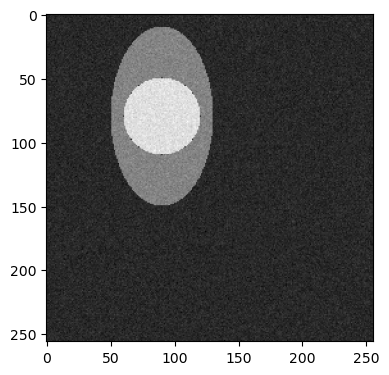

In [32]:
# Create a coordinate grid (256x256) using meshgrid
xx, yy = np.meshgrid(np.arange(256), np.arange(256))
# Initialize a blank grayscale image (256x256) filled with zeros
img = np.zeros((256, 256))

# Define a circular region centered at (90, 80) with a radius of 30 pixels
rr0 = (xx-90)**2 + (yy-80)**2
# Assign pixel intensity 20 to this circular region
img[rr0 < 30**2] = 20.0

# Define an elliptical region surrounding the circular region
# The equation represents an ellipse centered at (90, 80) with axes (40, 70)
rr1 = (xx-90)**2/40**2 + (yy-80)**2/70**2

# Assign intensity 10 to the contiguous elliptical region outside the initial circle
# The condition ensures the pixels belong to the elliptical region but not the inner circle
img[(rr0 > 30.0**2)*(rr1 < 1.0)] = 10.0

# Apply Gaussian noise to the image using a predefined function
img = regionGrowing.gaussian_noise(image=img, sigma=1)

plot_images([img], figsize=(4,8), hideAxis=False)
# plt.imshow(img, cmap="gray")

### Define a seed in the image

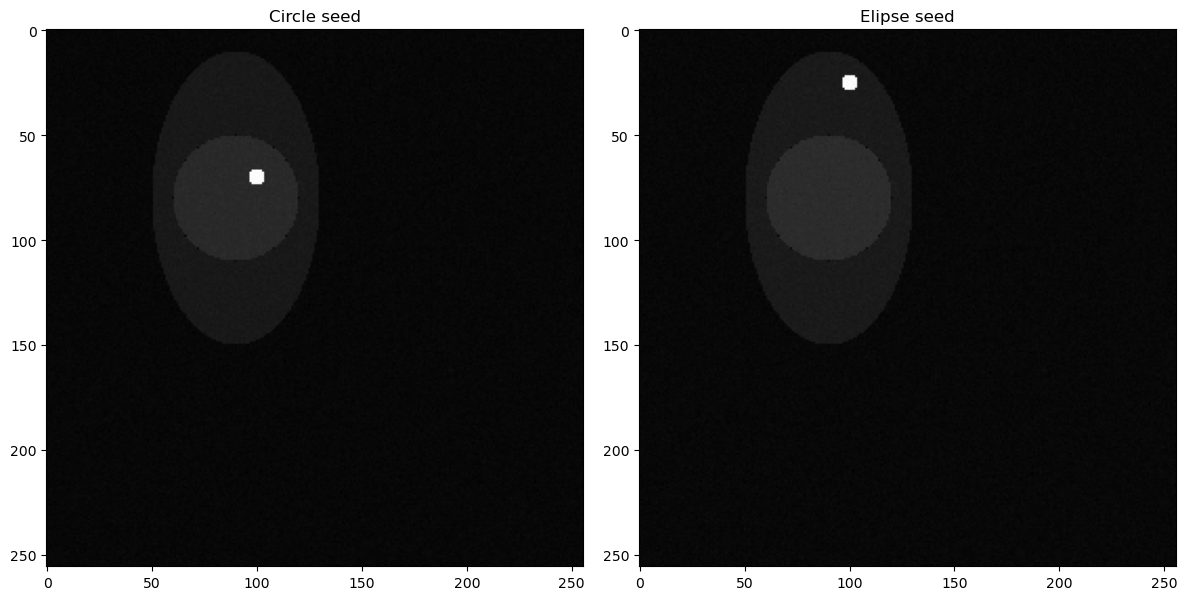

In [33]:
# using a sedd
circle_seed = (100, 70)
ellipse_seed = (100, 25)

# draw a circle around the seed
circle_flag =  regionGrowing.set_seed(image=img, seed=circle_seed, seed_size=4)
ellipse_flag =  regionGrowing.set_seed(image=img, seed=ellipse_seed, seed_size=4)

labels = ["Circle seed", "Elipse seed"]

plot_images([circle_flag, ellipse_flag], labels, hideAxis=False)

### Plot the region

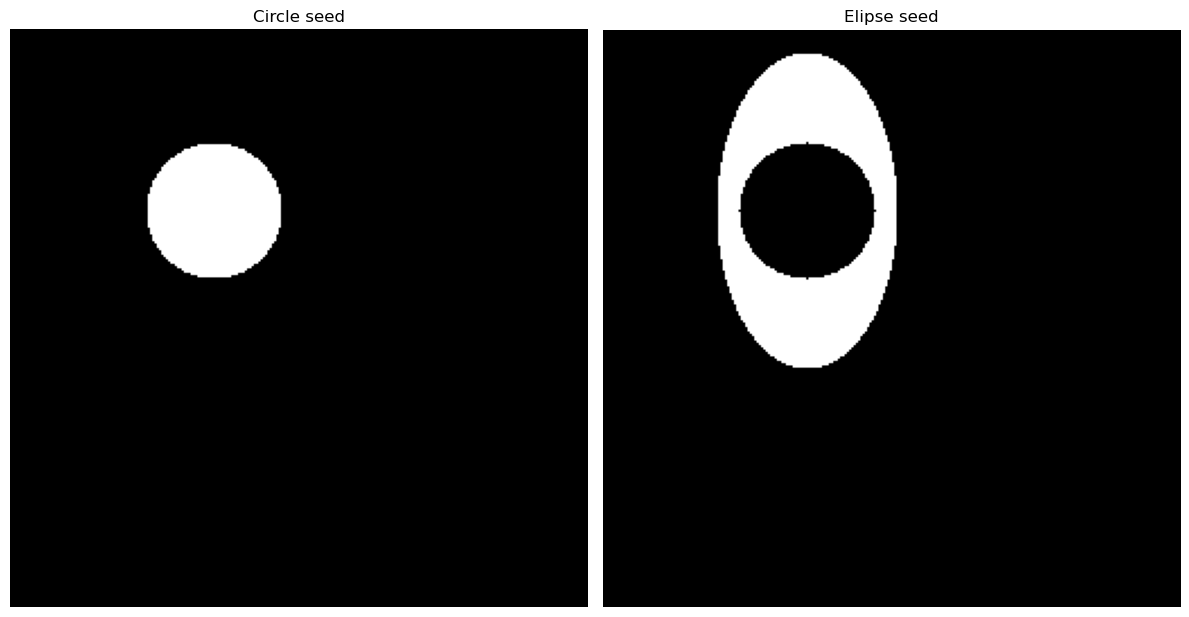

In [38]:
circle_mask = regionGrowing(seed=circle_seed, image=img, threshold=4)
elipse_mask = regionGrowing(seed=ellipse_seed, image=img, threshold=4)

plot_images([circle_mask, elipse_mask], labels)

### Region Growing applied

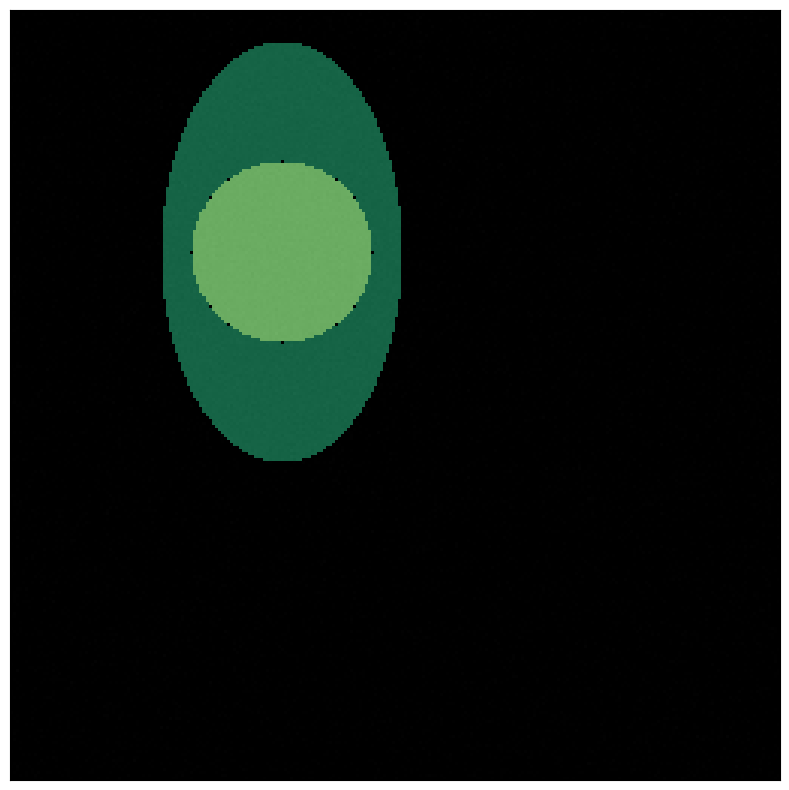

In [39]:
# Convert grayscale image to 3-channel (RGB) by stacking it three times
img_rgb = np.stack([img] * 3, axis=-1)  # Shape becomes (H, W, 3)

# Normalize values to [0, 255] and convert to uint8
img_rgb = np.clip(img_rgb, 0, 255).astype(np.uint8)

masks = [circle_mask, elipse_mask]

ellipse_circle = regionGrowing.plot_region_growing(image=img_rgb, masks=masks)
plot_images([ellipse_circle])
# np.asarray(img)

## Region growing in medical imaging

In [40]:
corp_image = cv2.imread("data/corps.JPG")
gray_corps_image = cv2.cvtColor(corp_image, cv2.COLOR_BGR2GRAY)

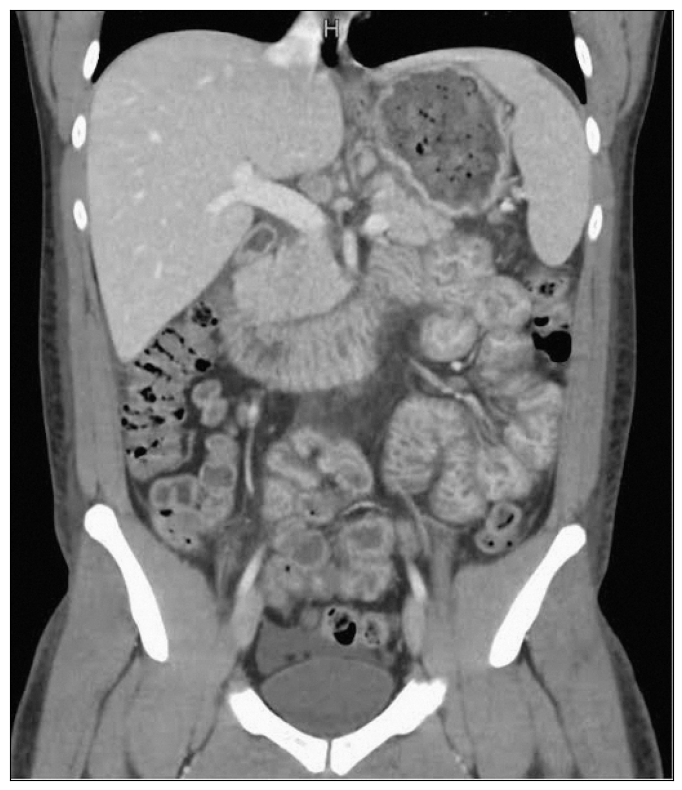

In [41]:
gray_corps_image = regionGrowing.gaussian_noise(image=gray_corps_image, sigma=1.5)
plot_images([gray_corps_image])

### Choose seeds in the image

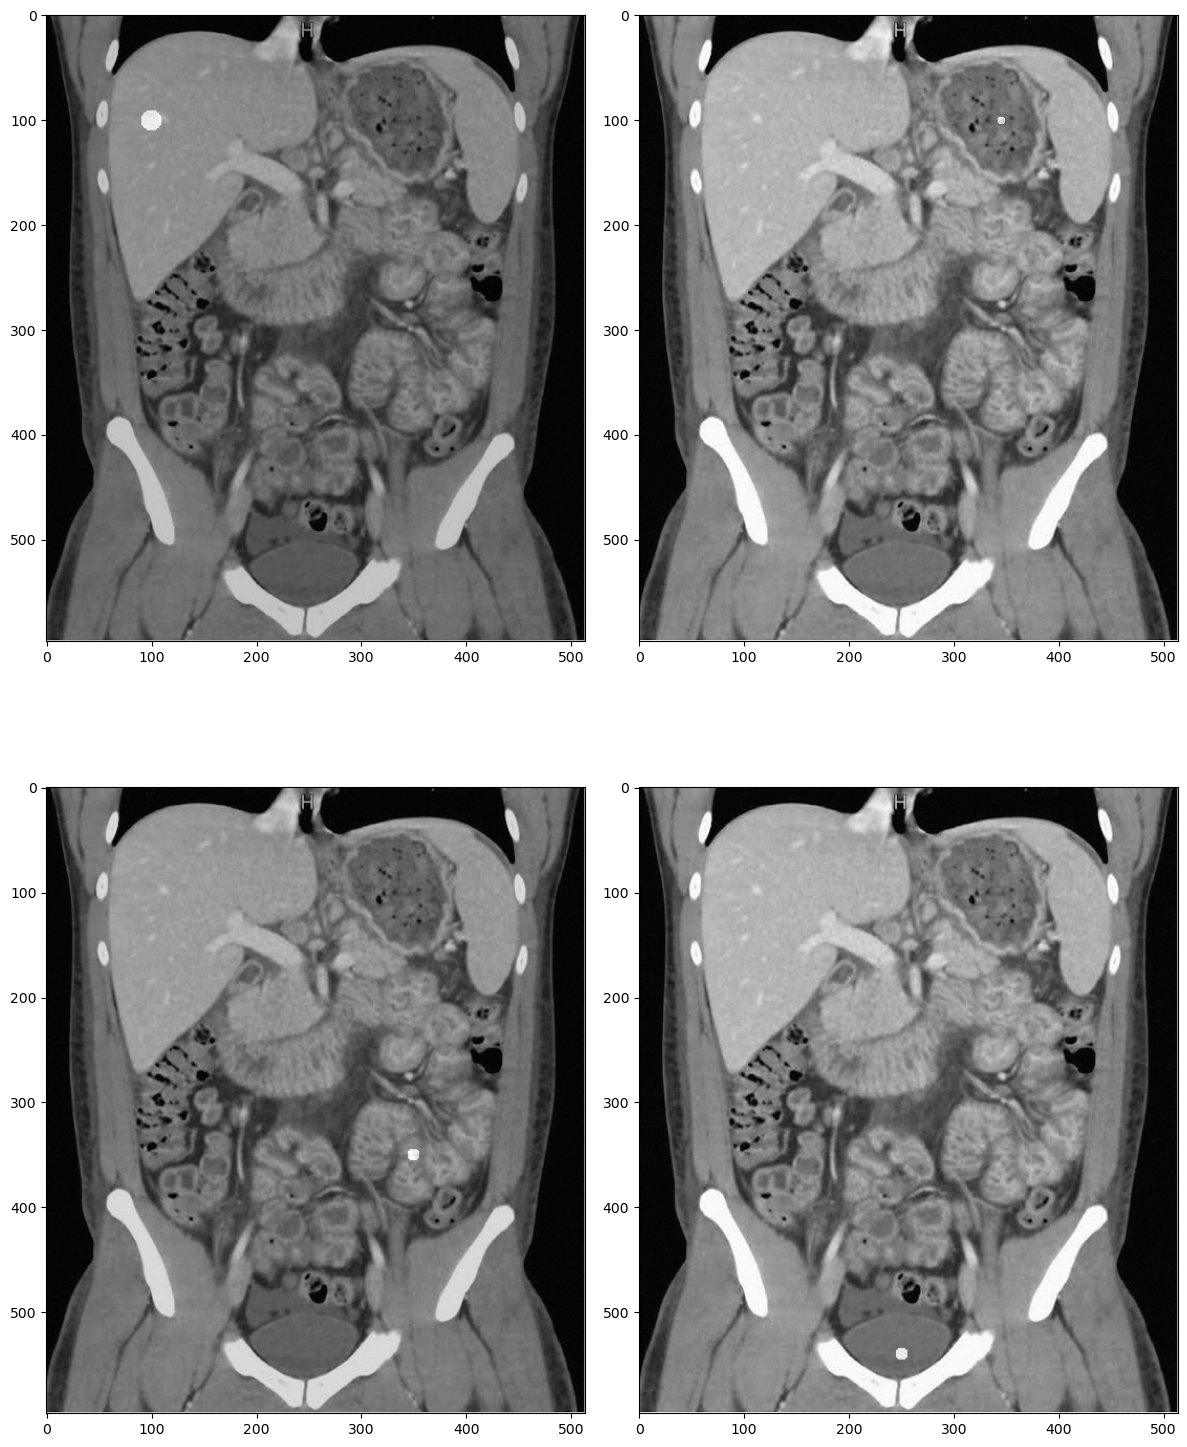

In [42]:
corps_seed = (100, 100)
corps_seed2 = (345,100)
corps_seed3 = (350, 350)
corps_seed4 = (250,540)

seed_img1 = regionGrowing.set_seed(gray_corps_image, corps_seed, 10)
seed_img2 = regionGrowing.set_seed(gray_corps_image, corps_seed2, 4)
seed_img3 = regionGrowing.set_seed(gray_corps_image, corps_seed3, 6)
seed_img4 = regionGrowing.set_seed(gray_corps_image, corps_seed4, 6)

plot_images([seed_img1, seed_img2, seed_img3, seed_img4], hideAxis=False, figsize=(12,16), ncols=2, nrows=2)

### Plot the region mask

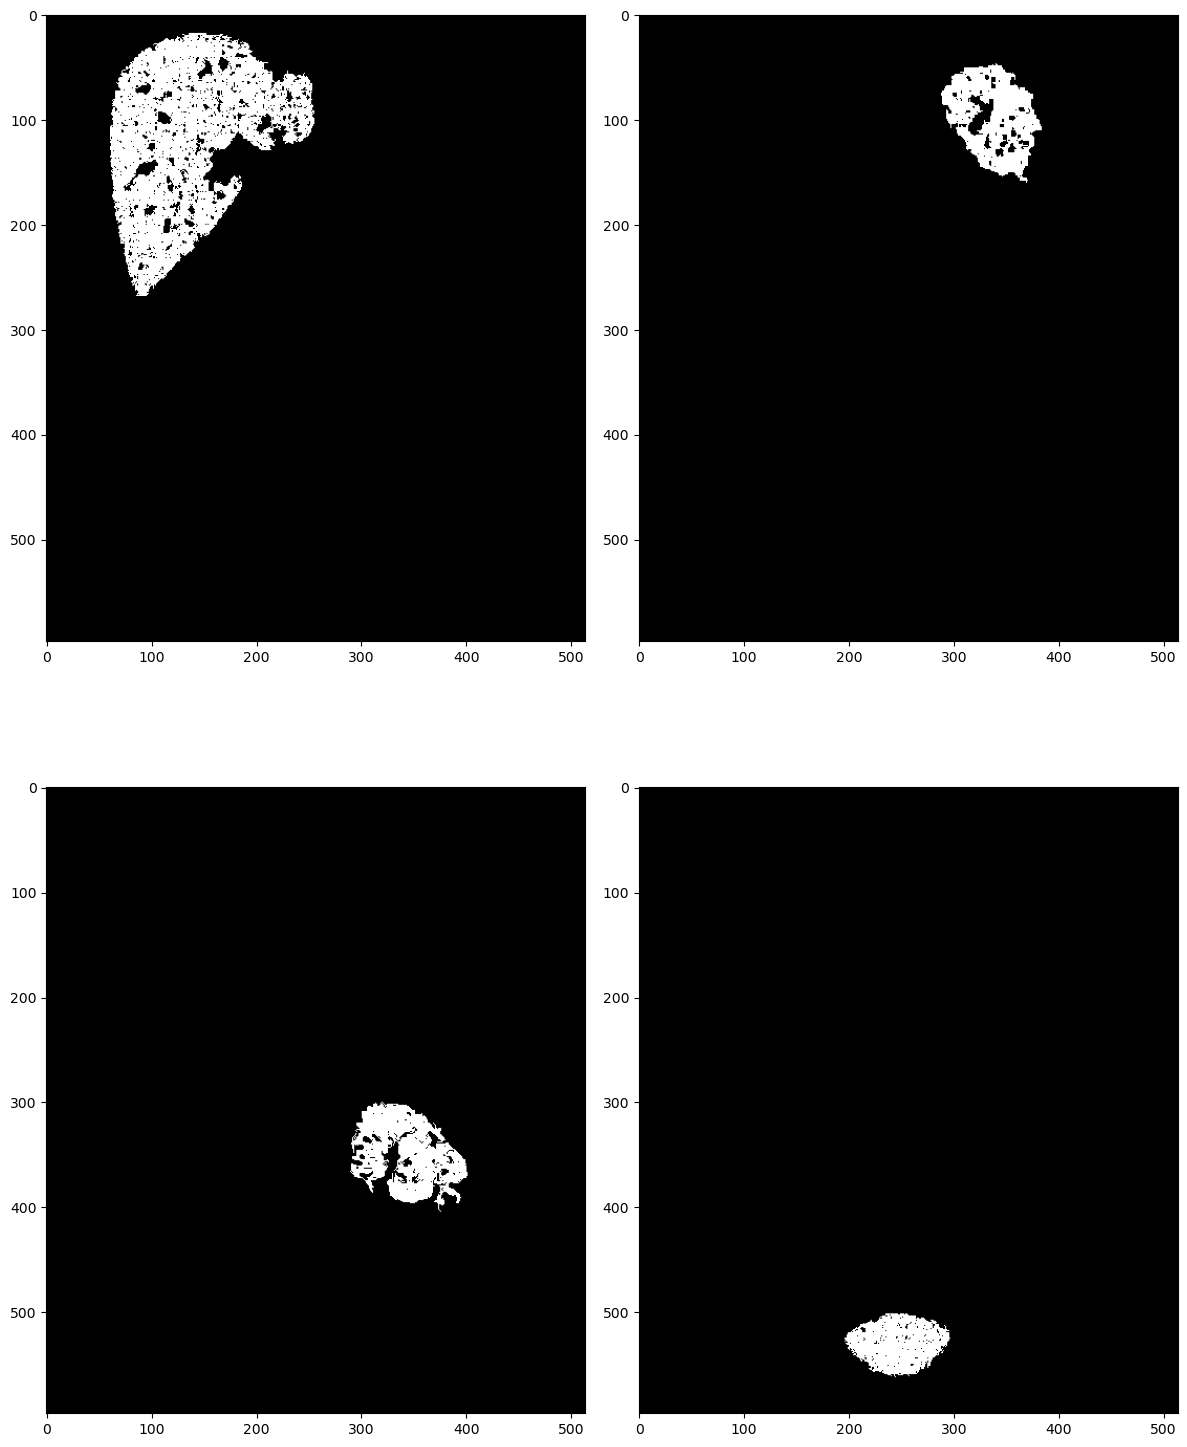

In [43]:
corps_mask = regionGrowing(seed=corps_seed, image=gray_corps_image, threshold=2, dist=8)
corps_organ_mask2 = regionGrowing(seed=corps_seed2, image=gray_corps_image, threshold= 5, dist=4)
corps_organ_mask3 = regionGrowing(seed=corps_seed3, image=gray_corps_image, threshold= 4, dist=8)
corps_organ_mask4 = regionGrowing(seed=corps_seed4, image=gray_corps_image, threshold= 2, dist=8)

plot_images([corps_mask, corps_organ_mask2, corps_organ_mask3, corps_organ_mask4], hideAxis=False, figsize=(12,16), ncols=2, nrows=2)

### Region Growing applied

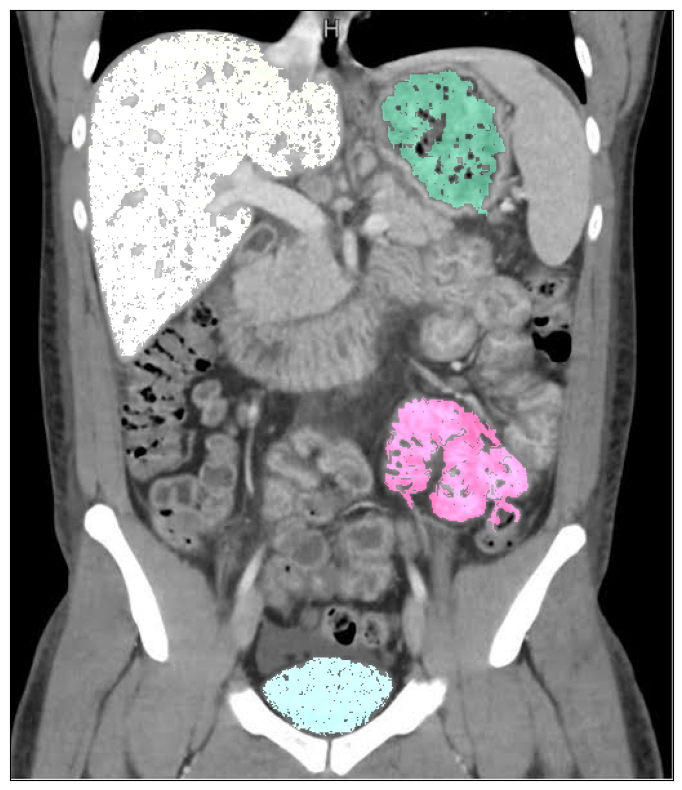

In [44]:
masks = [corps_mask, corps_organ_mask2, corps_organ_mask3, corps_organ_mask4]

final_image = regionGrowing.plot_region_growing(image=corp_image, masks=masks)

plot_images([final_image], hideAxis=True)

### References

* Author(s). (1997, August). Region growing and region merging image segmentation. In Digital Signal Processing Proceedings, 1997. DSP 97., 1997 13th International Conference on (Vol. 1). IEEE. https://doi.org/10.1109/ICDSP.1997.628077

* Bagohil, M. (n.d.). Region growing: An inclusive overview from concept to code in image segmentation. Medium. https://medium.com/@mansibagohil1512/region-growing-an-inclusive-overview-from-concept-to-code-in-image-segmentation-f12c5ba50709

* Real-World Science. (2023, October 15). The fascinating world of quantum mechanics [Video]. YouTube. https://www.youtube.com/watch?v=6E9jD4rEuPY

* Region Growing -- Implementation (Image Processing). (2024). YouTube. https://www.youtube.com/watch?v=lGqNAdlFzgk
